# Plant Seedlings Classification
This is a kaggle compitition named [Plant Seedlings Classification](https://www.kaggle.com/c/plant-seedlings-classification). We need to determine the species of a seedling from an image

In [0]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# 1.1 Install and Importing libraries

In [0]:
!pip install fastai
# https://opencv.org/
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python
# http://pytorch.org/
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.0.post4-{platform}-linux_x86_64.whl torchvision

In [0]:
# This file contains all the main external libs we'll use
from fastai.imports import *
from fastai.torch_imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

import cv2
import torch

In [0]:
PATH = '/content/data/'

# 1.2 Collecting data

In [0]:
!mkdir data

In [0]:
cd data

In [0]:
!kg download -u puzzlemusa -p puzzlemusa13 -c plant-seedlings-classification

In [0]:
!unzip test.zip
!unzip train.zip

In [89]:
cd test

/content/data/test


In [90]:
!find . -type f | wc -l

794


In [0]:
os.listdir(PATH)

In [0]:
files = os.listdir(f'{PATH}test')[:5]
files

In [0]:
import matplotlib.pyplot as plt
img = plt.imread(f'{PATH}test/{files[2]}')
plt.imshow(img);

In [0]:
img.shape

In [0]:
img[:4,:4]

# 1.3  Creating validation data

In [0]:
val_path = PATH + 'valid/'
if(not os.path.exists(val_path)):
  os.mkdir(val_path)

In [0]:
val_split = .2
for dir in os.listdir(PATH+'train/'):
  src_dir, val_dir = os.path.join(PATH+'train/', dir), os.path.join(PATH+'valid/', dir)
  no_of_files_to_mv = int(len(os.listdir(src_dir)) * val_split )
  
  if(not os.path.exists(val_dir)):
    os.mkdir(val_dir)
  
  c = 0;
  for file in os.listdir(src_dir):
    if(c > no_of_files_to_mv):
      break  
    
    if os.path.isfile(os.path.join(src_dir, file)):
      src_file, dest_file = os.path.join(src_dir, file), os.path.join(val_dir, file)
      os.rename(src_file,dest_file)
      c = c + 1

# 2.1 Creating Dataset

In [0]:
def get_data(sz):
  tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
  return ImageClassifierData.from_paths(PATH, tfms=tfms, test_name='test')

# 2.2 Exploring data

In [0]:
sz = 64
arch=resnet50

In [0]:
data = get_data(sz)

In [0]:
size_d = {k: PIL.Image.open(PATH+k). size for k in data.trn_ds.fnames}

In [0]:
row_sz, col_sz = list(zip(*size_d.values()))

In [0]:
row_sz=np.array(row_sz); col_sz=np.array(col_sz)

In [123]:
row_sz[:5]

array([531,  78, 751, 625, 906])

(array([2442., 1006.,  223.,   91.,   15.,    6.,    4.,    2.,    1.,    1.]),
 array([  49. ,  409.3,  769.6, 1129.9, 1490.2, 1850.5, 2210.8, 2571.1, 2931.4, 3291.7, 3652. ]),
 <a list of 10 Patch objects>)

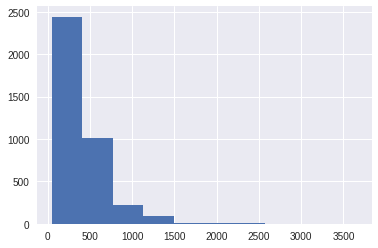

In [124]:
plt.hist(row_sz)

(array([315., 603., 618., 259., 139., 130., 143., 231., 184., 204.]),
 array([ 49.,  94., 139., 184., 229., 274., 319., 364., 409., 454., 499.]),
 <a list of 10 Patch objects>)

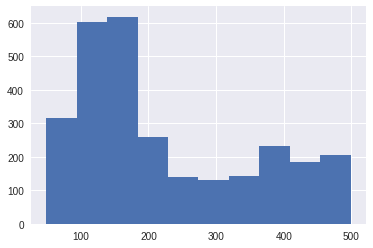

In [125]:
plt.hist(row_sz[row_sz<500])

In [126]:
len(data.trn_ds)

3791

In [127]:
len(data.test_ds)

794

# 2.3 Choosing a learning rate

In [0]:
data = get_data(sz)

In [128]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

100%|██████████| 13/13 [00:02<00:00,  5.32it/s]


In [129]:
lrf=learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 88%|████████▊ | 53/60 [00:00<00:00, 54.20it/s, loss=11]  


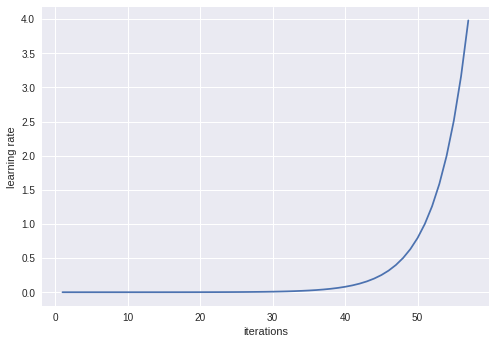

In [20]:
learn.sched.plot_lr()

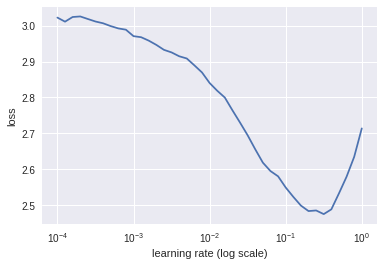

In [130]:
learn.sched.plot()

# 3.1 Initial model

In [0]:
data = get_data(299)
learn = ConvLearner.pretrained(arch, data, precompute=True, ps = .5)

In [21]:
learn.fit(.1, 5)

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

[0.      1.42988 0.80437 0.76531]
[1.      0.9614  0.63458 0.81448]
[2.      0.73431 0.5493  0.83431]
[3.      0.57402 0.50372 0.85509]
[4.      0.4811  0.46485 0.8541 ]



In [22]:
learn.precompute = False
learn.fit(.1, 5, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

[0.      0.4774  0.31494 0.8874 ]
[1.      0.45518 0.31782 0.88747]
[2.      0.43376 0.2966  0.89578]
[3.      0.41207 0.2969  0.89785]
[4.      0.39892 0.3165  0.89785]



In [23]:
learn.fit(.1, 3, cycle_len=1, cycle_mult=3)

HBox(children=(IntProgress(value=0, description='Epoch', max=13), HTML(value='')))

[0.      0.38337 0.27538 0.90203]
[1.      0.40098 0.32048 0.88223]
[2.      0.39508 0.2898  0.90307]
[3.      0.34486 0.26645 0.90203]
[4.      0.3623  0.28751 0.89889]
 80%|████████  | 48/60 [01:07<00:16,  1.41s/it, loss=0.374]

[5.      0.37359 0.27891 0.90724]
[6.      0.35477 0.30258 0.89477]
[7.      0.3369  0.25164 0.91141]
[8.      0.32144 0.26834 0.90402]
[9.      0.29218 0.2658  0.90622]


[10.       0.25742  0.24436  0.91351]
[11.       0.25212  0.24655  0.92392]
[12.       0.25341  0.25361  0.91351]



# 3.2 Increase size

In [0]:
sz = 400

In [18]:
data = get_data(sz)
learn.set_data(data)
learn.freeze()
learn.fit(.1, 3)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[0.      1.86568 1.37154 0.51384]
[1.      1.56185 1.2741  0.54001]
[2.      1.40797 1.18609 0.57768]



In [19]:
learn.precompute = False
learn.fit(.1, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

[0.      1.26614 1.13873 0.58719]
[1.      1.25796 1.13029 0.58398]
[2.      1.16245 1.09872 0.5997 ]
[3.      1.20014 1.12295 0.58917]
[4.      1.16673 1.07103 0.60579]
[5.      1.10558 1.04004 0.62467]
 10%|█         | 6/60 [00:04<00:40,  1.34it/s, loss=1.09]

[6.      1.04763 1.05052 0.6143 ]



# 4 Create submission file

In [30]:
log_preds, y = learn.TTA(is_test=True)
probs = np.exp(log_preds)
accuracy(log_preds, y), metrics.log_loss(y, probs)

ValueError: ignored

In [31]:
y.shape

(794, 1)

In [34]:
#preds = np.unravel_index(np.argmax(probs), probs.shape)
preds = np.argmax(probs, axis=1)
preds

array([ 1,  1,  8,  2,  0,  5,  9,  7,  1, 11,  8,  4,  3, 11,  6,  6,  2, 10,  8,  5, 11,  2,  8, 10,  5,
       10,  6,  0, 11, 10,  6,  3,  5,  2,  6,  6, 10,  6,  6,  3,  4,  9,  8,  9,  3,  6,  5,  9,  2,  2,
        2,  3,  8,  6, 11,  8,  5, 10,  4,  5,  6,  3,  8,  7,  1,  5,  2,  8, 10,  5,  7,  5,  3,  6, 10,
        9, 10,  8,  0, 11, 11,  7,  6,  6,  6,  3,  8,  6,  1,  6, 10, 10,  5,  2,  5,  8,  6, 11,  9,  8,
        3,  6,  5,  6,  2, 10,  6,  6,  8,  5, 11,  6,  6,  6,  6,  6, 11,  2,  3,  3,  7,  5,  1, 11, 11,
        7, 10,  7,  2,  3,  3,  6,  2, 11,  1,  0,  1, 10,  1,  4,  4, 11,  8,  4,  5,  6,  6,  8, 11,  4,
        5,  7,  8, 10, 10, 10, 10,  7, 10,  7,  8, 11,  7,  3, 10, 11,  6,  6,  4,  2,  3, 10,  3,  3, 11,
        5,  8,  6, 10,  4,  6,  6,  3, 11,  6, 11,  2,  6,  9,  6,  5,  6, 11,  3,  8,  5, 11,  9,  9,  6,
        1,  7,  3, 10,  1,  4,  8,  1,  8,  2,  5,  6, 11,  8,  3, 10,  6,  3,  6,  6,  3,  3,  1,  6, 10,
        7,  6,  6,  6,  6,  8,  6,  6

In [0]:
rst = np.array([(data.classes[pp]) for pp in preds])

In [0]:
filenames = np.array([os.path.basename(fn)for fn in data.test_ds.fnames])

In [0]:
df = pd.DataFrame(rst, index=filenames, columns=['species'])
df.to_csv(f'{PATH}rst.csv', index_label='file')

In [0]:
df.sort_values(by=['file'])

In [45]:
df.head()

,species
cbe761896.png,Charlock
808578ed5.png,Charlock
90d119d25.png,Scentless Mayweed
6bce55e05.png,Cleavers
026716f9b.png,Black-grass


In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once in a notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [43]:
# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Create & upload a file.
uploaded = drive.CreateFile({'title': 'rst.csv'})
uploaded.SetContentFile('/content/data/rst.csv')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

Uploaded file with ID 1PRCcXgvRx99X9y6eklEnw0U_Mib1fZyX


In [41]:
!kg submit '/content/data/rst.csv' -u puzzlemusa -p puzzlemusa13 -c plant-seedlings-classification -m "1st try from colab after formatting"

^C
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 380, in _make_request
    httplib_response = conn.getresponse(buffering=True)
TypeError: getresponse() got an unexpected keyword argument 'buffering'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/bin/kg", line 11, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.6/dist-packages/kaggle_cli/main.py", line 21, in main
    return app.run(argv)
  File "/usr/local/lib/python3.6/dist-packages/cliff/app.py", line 279, in run
    result = self.run_subcommand(remainder)
  File "/usr/local/lib/python3.6/dist-packages/cliff/app.py", line 400, in run_subcommand
    result = cmd.run(parsed_args)
  File "/usr/local/lib/python3.6/dist-packages/cliff/command.py", line 137, in run
    return_code = self.take_action(parsed_args) or 0
  File "/usr/local/lib/python3.6/dist-packages/kaggle_cli/submit